In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
import cvxEDA
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
import scipy.signal as scisig

df_EDA = pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\migraines\raw_20180613\Dataexport\EDA.csv', names=["EDA"])
df_TEMP = pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\migraines\raw_20180613\Dataexport\TEMP.csv', names=["TEMP"])
df_HR = pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\migraines\raw_20180613\Dataexport\HR.csv', names=["HR"])
df_pain= pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\migraines\MG2318003_mig_3_20180613.csv', names=["pain","EDA","TEMP","HR"])

if (len(df_EDA)-len(df_TEMP)!=0):
    if(len(df_EDA)>len(df_TEMP)):
        df_EDA.drop(df_EDA.tail(len(df_EDA)-len(df_TEMP)).index,inplace=True)
    else:
        df_TEMP.drop(df_TEMP.tail(len(df_TEMP)-len(df_EDA)).index,inplace=True) 

pain=df_pain['pain']
pain.drop(pain.tail(1).index,inplace=True)
pain.drop(pain.head(60).index,inplace=True)
pain.index = range(0,len(pain) )

df_EDA.drop([0,1], inplace=True)
df_TEMP.drop([0,1], inplace=True)
df_HR.drop([0,1], inplace=True)

fs={'EDA':4, 'TEMP':4, 'HR':1}

df_EDAmean5=[]
df_EDAmean15=[]
df_EDAmean30=[]
df_EDAmean=[df_EDAmean5,df_EDAmean15,df_EDAmean30] 
df_EDAstd5=[]
df_EDAstd15=[]
df_EDAstd30=[]
df_EDAstd=[df_EDAstd5,df_EDAstd15,df_EDAstd30] 
df_EDAmax5=[]
df_EDAmax15=[]
df_EDAmax30=[]
df_EDAmax=[df_EDAmax5,df_EDAmax15,df_EDAmax30] 
df_EDAmin5=[]
df_EDAmin15=[]
df_EDAmin30=[]
df_EDAmin=[df_EDAmin5,df_EDAmin15,df_EDAmin30] 
df_EDAmaxdiff5=[]
df_EDAmaxdiff15=[]
df_EDAmaxdiff30=[]
df_EDAmaxdiff=[df_EDAmaxdiff5,df_EDAmaxdiff15,df_EDAmaxdiff30]

df_TEMPmean5=[]
df_TEMPmean15=[]
df_TEMPmean30=[]
df_TEMPmean=[df_TEMPmean5,df_TEMPmean15,df_TEMPmean30] 
df_TEMPstd5=[]
df_TEMPstd15=[]
df_TEMPstd30=[]
df_TEMPstd=[df_TEMPstd5,df_TEMPstd15,df_TEMPstd30] 
df_TEMPmax5=[]
df_TEMPmax15=[]
df_TEMPmax30=[]
df_TEMPmax=[df_TEMPmax5,df_TEMPmax15,df_TEMPmax30] 
df_TEMPmin5=[]
df_TEMPmin15=[]
df_TEMPmin30=[]
df_TEMPmin=[df_TEMPmin5,df_TEMPmin15,df_TEMPmin30] 
df_TEMPmaxdiff5=[]
df_TEMPmaxdiff15=[]
df_TEMPmaxdiff30=[]
df_TEMPmaxdiff=[df_TEMPmaxdiff5,df_TEMPmaxdiff15,df_TEMPmaxdiff30] 

df_HRmean5=[]
df_HRmean15=[]
df_HRmean30=[]
df_HRmean=[df_HRmean5,df_HRmean15,df_HRmean30] 
df_HRstd5=[]
df_HRstd15=[]
df_HRstd30=[]
df_HRstd=[df_HRstd5,df_HRstd15,df_HRstd30] 
df_HRmax5=[]
df_HRmax15=[]
df_HRmax30=[]
df_HRmax=[df_HRmax5,df_HRmax15,df_HRmax30] 
df_HRmin5=[]
df_HRmin15=[]
df_HRmin30=[]
df_HRmin=[df_HRmin5,df_HRmin15,df_HRmin30] 
df_HRmaxdiff5=[]
df_HRmaxdiff15=[]
df_HRmaxdiff30=[]
df_HRmaxdiff=[df_HRmaxdiff5,df_HRmaxdiff15,df_HRmaxdiff30]

windsize=[5,15,30]    

#Pasamos filtro
# https://github.com/MITMediaLabAffectiveComputing/eda-explorer/blob/master/load_files.py
def butter_lowpass(cutoff, fs, order=5):
    # Filtering Helper functions
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scisig.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    # Filtering Helper functions
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = scisig.lfilter(b, a, data)
    return y

# Filter EDA
df_EDA['EDA'] = butter_lowpass_filter(df_EDA['EDA'], 1.0, fs['EDA'], 6)
df_TEMP['TEMP'] = butter_lowpass_filter(df_TEMP['TEMP'], 0.001, fs['TEMP'], 3)
df_HR['HR'] = butter_lowpass_filter(df_HR['HR'], 0.001, fs['HR'],3 )

n=0
for i in range(fs['TEMP']*60-1, len(df_TEMP), fs['TEMP']*60):
    for j in windsize:
        if(i-fs['TEMP']*j*60+1<0):
            window=df_TEMP['TEMP'][0:i]
        else:
            window=df_TEMP['TEMP'][i-fs['TEMP']*60*j+1:i]
        
        
        mean=np.mean(window)
        std=np.std(window)
        max_=window.max()
        min_=window.min()
        dif=np.diff(window)
        if (np.abs(dif.max())>=np.abs(dif.min())):
            maxdif=dif.max()
        else:
            maxdif=dif.min()

        df_TEMPmean[n].append(mean)
        df_TEMPstd[n].append(std)
        df_TEMPmax[n].append(max_)
        df_TEMPmin[n].append(mean)
        df_TEMPmaxdiff[n].append(maxdif)
        
        n+=1
    n=0

n=0
for i in range(fs['HR']*60-1, len(df_HR), fs['HR']*60):
    for j in windsize:
        if(i-fs['HR']*j*60+1<0):
            window=df_HR['HR'][0:i]
        else:
            window=df_HR['HR'][i-fs['HR']*60*j+1:i]
        
        
        mean=np.mean(window)
        std=np.std(window)
        max_=window.max()
        min_=window.min()
        dif=np.diff(window)
        if (np.abs(dif.max())>=np.abs(dif.min())):
            maxdif=dif.max()
        else:
            maxdif=dif.min()

        df_HRmean[n].append(mean)
        df_HRstd[n].append(std)
        df_HRmax[n].append(max_)
        df_HRmin[n].append(mean)
        df_HRmaxdiff[n].append(maxdif)
        
        n+=1
    n=0

d={'meanTEMP5':df_TEMPmean5,'meanHR5':df_HRmean5,'meanTEMP15':df_TEMPmean15,'meanHR15':df_HRmean15,'meanTEMP30':df_TEMPmean30,'meanHR30':df_HRmean30,'stdTEMP5':df_TEMPstd5,'stdHR5':df_HRstd5,'stdTEMP15':df_TEMPstd15,'stdHR15':df_HRstd15,'stdTEMP30':df_TEMPstd30,'stdHR30':df_HRstd30,'maxTEMP5':df_TEMPmax5,'maxHR5':df_HRmax5,'maxTEMP15':df_TEMPmax15,'maxHR15':df_HRmax15,'maxTEMP30':df_TEMPmax30,'maxHR30':df_HRmax30,'minTEMP5':df_TEMPmin5,'minHR5':df_HRmin5,'minTEMP15':df_TEMPmin15,'minHR15':df_HRmin15,'minTEMP30':df_TEMPmin30,'minHR30':df_HRmin30,'maxdiffTEMP5':df_TEMPmaxdiff5,'maxdiffHR5':df_HRmaxdiff5,'maxdiffTEMP15':df_TEMPmaxdiff15,'maxdiffHR15':df_HRmaxdiff15,'maxdiffTEMP30':df_TEMPmaxdiff30,'maxdiffHR30':df_HRmaxdiff30}
df=pd.DataFrame(data=d)    

def eda_stats(y):
    Fs = fs['EDA']
    yn = (y - y.mean()) / y.std()
    [r, p, t, l, d, e, obj] = cvxEDA.cvxEDA(yn, 1. / Fs)
    return [r, p, t, l, d, e, obj]

r, p, t, l, d, e, obj = eda_stats(df_EDA['EDA'])
df_EDA['EDA_phasic'] = r
df_EDA['EDA_smna'] = p
df_EDA['EDA_tonic'] = t

n=0
for l in windsize:
        df_EDAmean[n].clear()
        df_EDAstd[n].clear()
        df_EDAmax[n].clear()
        df_EDAmin[n].clear()
        df_EDAmaxdiff[n].clear()
        n+=1
n=0        
for i in range(fs['EDA']*60-1, len(df_EDA), fs['EDA']*60):
    for j in windsize:
        if(i-fs['EDA']*j*60+1<0):
            window=df_EDA['EDA_phasic'][0:i]
        else:
            window=df_EDA['EDA_phasic'][i-fs['EDA']*60*j+1:i]
 

        
        mean=np.mean(window)
        std=np.std(window)
        max_=window.max()
        min_=window.min()
        dif=np.diff(window)
        if (np.abs(dif.max())>=np.abs(dif.min())):
            maxdif=dif.max()
        else:
            maxdif=dif.min()

        df_EDAmean[n].append(mean)
        df_EDAstd[n].append(std)
        df_EDAmax[n].append(max_)
        df_EDAmin[n].append(mean)
        df_EDAmaxdiff[n].append(maxdif)
        
        n+=1
    n=0
    

df['meanEDA_phasic5']=df_EDAmean5  
df['meanEDA_phasic15']=df_EDAmean15  
df['meanEDA_phasic30']=df_EDAmean30  

df['stdEDA_phasic5']=df_EDAstd5 
df['stdEDA_phasic15']=df_EDAstd15 
df['stdEDA_phasic30']=df_EDAstd30 

df['maxEDA_phasic5']=df_EDAmax5 
df['maxEDA_phasic15']=df_EDAmax15 
df['maxEDA_phasic30']=df_EDAmax30 

df['minEDA_phasic5']=df_EDAmin5 
df['minEDA_phasic15']=df_EDAmin15 
df['minEDA_phasic30']=df_EDAmin30 

df['maxdiffEDA_phasic5']=df_EDAmaxdiff5
df['maxdiffEDA_phasic15']=df_EDAmaxdiff15
df['maxdiffEDA_phasic30']=df_EDAmaxdiff30

n=0
for l in windsize:
        df_EDAmean[n].clear()
        df_EDAstd[n].clear()
        df_EDAmax[n].clear()
        df_EDAmin[n].clear()
        df_EDAmaxdiff[n].clear()
        n+=1
n=0        
for i in range(fs['EDA']*60-1, len(df_EDA), fs['EDA']*60):
    for j in windsize:
        if(i-fs['EDA']*j*60+1<0):
            window=df_EDA['EDA_tonic'][0:i]
        else:
            window=df_EDA['EDA_tonic'][i-fs['EDA']*60*j+1:i]
 

        
        mean=np.mean(window)
        std=np.std(window)
        max_=window.max()
        min_=window.min()
        dif=np.diff(window)
        if (np.abs(dif.max())>=np.abs(dif.min())):
            maxdif=dif.max()
        else:
            maxdif=dif.min()

        df_EDAmean[n].append(mean)
        df_EDAstd[n].append(std)
        df_EDAmax[n].append(max_)
        df_EDAmin[n].append(mean)
        df_EDAmaxdiff[n].append(maxdif)
        
        n+=1
    n=0
    
df['meanEDA_tonic5']=df_EDAmean5  
df['meanEDA_tonic15']=df_EDAmean15  
df['meanEDA_tonic30']=df_EDAmean30  
df['stdEDA_tonic5']=df_EDAstd5 
df['stdEDA_tonic15']=df_EDAstd15 
df['stdEDA_tonic30']=df_EDAstd30 
df['maxEDA_tonic5']=df_EDAmax5 
df['maxEDA_tonic15']=df_EDAmax15 
df['maxEDA_tonic30']=df_EDAmax30 
df['minEDA_tonic5']=df_EDAmin5 
df['minEDA_tonic15']=df_EDAmin15 
df['minEDA_tonic30']=df_EDAmin30 
df['maxdiffEDA_tonic5']=df_EDAmaxdiff5
df['maxdiffEDA_tonic15']=df_EDAmaxdiff15
df['maxdiffEDA_tonic30']=df_EDAmaxdiff30

n=0  

df_EDAcount5=[]
df_EDAcount15=[]
df_EDAcount30=[]
df_EDAcount=[df_EDAcount5,df_EDAcount15,df_EDAcount30] 
df_EDAsmax5=[]
df_EDAsmax15=[]
df_EDAsmax30=[]
df_EDAsmax=[df_EDAsmax5,df_EDAsmax15,df_EDAsmax30]

for i in range(fs['EDA']*60-1, len(df_EDA), fs['EDA']*60):
    for j in windsize:
        if(i-fs['EDA']*j*60+1<0):
            window=df_EDA['EDA_smna'][0:i]
        else:
            window=df_EDA['EDA_smna'][i-fs['EDA']*60*j+1:i] 
    
        max_=window.max()
        count=window[window > 1].count()


        
        df_EDAcount[n].append(count)
        df_EDAsmax[n].append(max_)

        
        n+=1
    n=0
    
df['countEDA_smna5']=df_EDAcount5 
df['countEDA_smna15']=df_EDAcount15
df['countEDA_smna30']=df_EDAcount30
df['maxEDA_smna5']=df_EDAsmax5
df['maxEDA_smna15']=df_EDAsmax15
df['maxEDA_smna30']=df_EDAsmax30

df.drop(df.tail(30).index,inplace=True)
df['pain']=pain

#df['pain']= np.zeros(len(df))
#df['pain']=-1
#df.to_csv(r'C:\Users\Carlos\Documents\UPM\TFM\Experiments_dataset\stadistics\Migraine7.csv', index=None, header=True)

     pcost       dcost       gap    pres   dres
 0: -2.8370e+05 -2.8130e+05  4e+06  2e+03  6e-01
 1: -2.8334e+05 -1.1234e+06  1e+06  4e+02  1e-01
 2: -2.8350e+05 -6.4086e+05  4e+05  1e+02  4e-02
 3: -2.8341e+05 -4.0529e+05  1e+05  3e+01  1e-02
 4: -2.8332e+05 -3.2816e+05  4e+04  1e+01  3e-03
 5: -2.8313e+05 -3.0214e+05  2e+04  3e+00  1e-03
 6: -2.8311e+05 -2.8999e+05  7e+03  9e-01  3e-04
 7: -2.8404e+05 -2.8549e+05  1e+03  6e-02  2e-05
 8: -2.8450e+05 -2.8534e+05  8e+02  2e-02  8e-06
 9: -2.8488e+05 -2.8528e+05  4e+02  5e-03  2e-06
10: -2.8508e+05 -2.8527e+05  2e+02  1e-03  4e-07
11: -2.8517e+05 -2.8526e+05  8e+01  3e-04  9e-08
12: -2.8521e+05 -2.8525e+05  4e+01  1e-04  3e-08
13: -2.8523e+05 -2.8525e+05  2e+01  3e-05  1e-08
14: -2.8524e+05 -2.8525e+05  1e+01  1e-05  3e-09
15: -2.8524e+05 -2.8525e+05  4e+00  3e-06  9e-10
16: -2.8525e+05 -2.8525e+05  2e+00  8e-07  3e-10
17: -2.8525e+05 -2.8525e+05  6e-01  2e-07  6e-11
18: -2.8525e+05 -2.8525e+05  2e-01  2e-08  8e-12
19: -2.8525e+05 -2.85

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
import cvxEDA
from IPython.display import display
import scipy.signal as scisig
import random
from sklearn.preprocessing import MinMaxScaler

df_EDA = pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\basals\raw_20180715\Dataexport\EDA.csv', names=["EDA"])
df_TEMP = pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\basals\raw_20180715\Dataexport\TEMP.csv', names=["TEMP"])
df_HR = pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\basals\raw_20180715\Dataexport\HR.csv', names=["HR"])
#df_pain= pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\migraines\MG2318003_mig_16_20180719.csv', names=["pain","EDA","TEMP","HR"])

if (len(df_EDA)-len(df_TEMP)!=0):
    if(len(df_EDA)>len(df_TEMP)):
        df_EDA.drop(df_EDA.tail(len(df_EDA)-len(df_TEMP)).index,inplace=True)
    else:
        df_TEMP.drop(df_TEMP.tail(len(df_TEMP)-len(df_EDA)).index,inplace=True) 



#pain=df_pain['pain']
#pain.drop(pain.tail(1).index,inplace=True)
#pain.drop(pain.head(60).index,inplace=True)
#pain.index = range(0,len(pain) )

df_EDA.drop([0,1], inplace=True)
df_TEMP.drop([0,1], inplace=True)
df_HR.drop([0,1], inplace=True)

fs={'EDA':4, 'TEMP':4, 'HR':1}

df_EDAmean5=[]
df_EDAmean15=[]
df_EDAmean30=[]
df_EDAmean=[df_EDAmean5,df_EDAmean15,df_EDAmean30] 
df_EDAstd5=[]
df_EDAstd15=[]
df_EDAstd30=[]
df_EDAstd=[df_EDAstd5,df_EDAstd15,df_EDAstd30] 
df_EDAmax5=[]
df_EDAmax15=[]
df_EDAmax30=[]
df_EDAmax=[df_EDAmax5,df_EDAmax15,df_EDAmax30] 
df_EDAmin5=[]
df_EDAmin15=[]
df_EDAmin30=[]
df_EDAmin=[df_EDAmin5,df_EDAmin15,df_EDAmin30] 
df_EDAmaxdiff5=[]
df_EDAmaxdiff15=[]
df_EDAmaxdiff30=[]
df_EDAmaxdiff=[df_EDAmaxdiff5,df_EDAmaxdiff15,df_EDAmaxdiff30]

df_TEMPmean5=[]
df_TEMPmean15=[]
df_TEMPmean30=[]
df_TEMPmean=[df_TEMPmean5,df_TEMPmean15,df_TEMPmean30] 
df_TEMPstd5=[]
df_TEMPstd15=[]
df_TEMPstd30=[]
df_TEMPstd=[df_TEMPstd5,df_TEMPstd15,df_TEMPstd30] 
df_TEMPmax5=[]
df_TEMPmax15=[]
df_TEMPmax30=[]
df_TEMPmax=[df_TEMPmax5,df_TEMPmax15,df_TEMPmax30] 
df_TEMPmin5=[]
df_TEMPmin15=[]
df_TEMPmin30=[]
df_TEMPmin=[df_TEMPmin5,df_TEMPmin15,df_TEMPmin30] 
df_TEMPmaxdiff5=[]
df_TEMPmaxdiff15=[]
df_TEMPmaxdiff30=[]
df_TEMPmaxdiff=[df_TEMPmaxdiff5,df_TEMPmaxdiff15,df_TEMPmaxdiff30] 

df_HRmean5=[]
df_HRmean15=[]
df_HRmean30=[]
df_HRmean=[df_HRmean5,df_HRmean15,df_HRmean30] 
df_HRstd5=[]
df_HRstd15=[]
df_HRstd30=[]
df_HRstd=[df_HRstd5,df_HRstd15,df_HRstd30] 
df_HRmax5=[]
df_HRmax15=[]
df_HRmax30=[]
df_HRmax=[df_HRmax5,df_HRmax15,df_HRmax30] 
df_HRmin5=[]
df_HRmin15=[]
df_HRmin30=[]
df_HRmin=[df_HRmin5,df_HRmin15,df_HRmin30] 
df_HRmaxdiff5=[]
df_HRmaxdiff15=[]
df_HRmaxdiff30=[]
df_HRmaxdiff=[df_HRmaxdiff5,df_HRmaxdiff15,df_HRmaxdiff30]

windsize=[5,15,30]    
window=1200
step=600

#Pasamos filtro
# https://github.com/MITMediaLabAffectiveComputing/eda-explorer/blob/master/load_files.py
def butter_lowpass(cutoff, fs, order=5):
    # Filtering Helper functions
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scisig.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    # Filtering Helper functions
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = scisig.lfilter(b, a, data)
    return y

# Filter EDA
df_EDA['EDA'] = butter_lowpass_filter(df_EDA['EDA'], 1.0, fs['EDA'], 6)
df_TEMP['TEMP'] = butter_lowpass_filter(df_TEMP['TEMP'], 0.001, fs['TEMP'], 3)
df_HR['HR'] = butter_lowpass_filter(df_HR['HR'], 0.001, fs['HR'],3 )

#Standarización
df_EDA['EDA']=(df_EDA['EDA']-df_EDA['EDA'].mean())/df_EDA['EDA'].std()
df_TEMP['TEMP']=(df_TEMP['TEMP']-df_TEMP['TEMP'].mean())/df_TEMP['TEMP'].std()
df_HR['HR']=(df_HR['HR']-df_HR['HR'].mean())/df_HR['HR'].std()

#Normalización
#scaler = MinMaxScaler()
#EDA_scaled=scaler.fit_transform(df_EDA)
#TEMP_scaled=scaler.fit_transform(df_TEMP)
#HR_scaled=scaler.fit_transform(df_HR)
#df_EDA['EDA']=EDA_scaled
#df_TEMP['TEMP'] = TEMP_scaled
#df_HR['HR'] = HR_scaled

#Preparamos las features
n=0
for i in range(fs['TEMP']*60-1, len(df_TEMP), fs['TEMP']*60):
    for j in windsize:
        if(i-fs['TEMP']*j*60+1<0):
            window=df_TEMP['TEMP'][0:i]
        else:
            window=df_TEMP['TEMP'][i-fs['TEMP']*60*j+1:i]
        
        
        mean=np.mean(window)
        std=np.std(window)
        max_=window.max()
        min_=window.min()
        dif=np.diff(window)
        if (np.abs(dif.max())>=np.abs(dif.min())):
            maxdif=dif.max()
        else:
            maxdif=dif.min()

        df_TEMPmean[n].append(mean)
        df_TEMPstd[n].append(std)
        df_TEMPmax[n].append(max_)
        df_TEMPmin[n].append(mean)
        df_TEMPmaxdiff[n].append(maxdif)
        
        n+=1
    n=0

n=0
for i in range(fs['HR']*60-1, len(df_HR), fs['HR']*60):
    for j in windsize:
        if(i-fs['HR']*j*60+1<0):
            window=df_HR['HR'][0:i]
        else:
            window=df_HR['HR'][i-fs['HR']*60*j+1:i]
        
        
        mean=np.mean(window)
        std=np.std(window)
        max_=window.max()
        min_=window.min()
        dif=np.diff(window)
        if (np.abs(dif.max())>=np.abs(dif.min())):
            maxdif=dif.max()
        else:
            maxdif=dif.min()

        df_HRmean[n].append(mean)
        df_HRstd[n].append(std)
        df_HRmax[n].append(max_)
        df_HRmin[n].append(mean)
        df_HRmaxdiff[n].append(maxdif)
        
        n+=1
    n=0

d={'meanTEMP5':df_TEMPmean5,'meanHR5':df_HRmean5,'meanTEMP15':df_TEMPmean15,'meanHR15':df_HRmean15,'meanTEMP30':df_TEMPmean30,'meanHR30':df_HRmean30,'stdTEMP5':df_TEMPstd5,'stdHR5':df_HRstd5,'stdTEMP15':df_TEMPstd15,'stdHR15':df_HRstd15,'stdTEMP30':df_TEMPstd30,'stdHR30':df_HRstd30,'maxTEMP5':df_TEMPmax5,'maxHR5':df_HRmax5,'maxTEMP15':df_TEMPmax15,'maxHR15':df_HRmax15,'maxTEMP30':df_TEMPmax30,'maxHR30':df_HRmax30,'minTEMP5':df_TEMPmin5,'minHR5':df_HRmin5,'minTEMP15':df_TEMPmin15,'minHR15':df_HRmin15,'minTEMP30':df_TEMPmin30,'minHR30':df_HRmin30,'maxdiffTEMP5':df_TEMPmaxdiff5,'maxdiffHR5':df_HRmaxdiff5,'maxdiffTEMP15':df_TEMPmaxdiff15,'maxdiffHR15':df_HRmaxdiff15,'maxdiffTEMP30':df_TEMPmaxdiff30,'maxdiffHR30':df_HRmaxdiff30}
df=pd.DataFrame(data=d)    

def eda_stats(y):
    Fs = fs['EDA']
    yn = (y - y.mean()) / y.std()
    [r, p, t, l, d, e, obj] = cvxEDA.cvxEDA(yn, 1. / Fs)
    return [r, p, t, l, d, e, obj]

r, p, t, l, d, e, obj = eda_stats(df_EDA['EDA'])
df_EDA['EDA_phasic'] = r
df_EDA['EDA_smna'] = p
df_EDA['EDA_tonic'] = t

n=0
for l in windsize:
        df_EDAmean[n].clear()
        df_EDAstd[n].clear()
        df_EDAmax[n].clear()
        df_EDAmin[n].clear()
        df_EDAmaxdiff[n].clear()
        n+=1
n=0        
for i in range(fs['EDA']*60-1, len(df_EDA), fs['EDA']*60):
    for j in windsize:
        if(i-fs['EDA']*j*60+1<0):
            window=df_EDA['EDA_phasic'][0:i]
        else:
            window=df_EDA['EDA_phasic'][i-fs['EDA']*60*j+1:i]
 

        
        mean=np.mean(window)
        std=np.std(window)
        max_=window.max()
        min_=window.min()
        dif=np.diff(window)
        if (np.abs(dif.max())>=np.abs(dif.min())):
            maxdif=dif.max()
        else:
            maxdif=dif.min()

        df_EDAmean[n].append(mean)
        df_EDAstd[n].append(std)
        df_EDAmax[n].append(max_)
        df_EDAmin[n].append(mean)
        df_EDAmaxdiff[n].append(maxdif)
        
        n+=1
    n=0
    

df['meanEDA_phasic5']=df_EDAmean5  
df['meanEDA_phasic15']=df_EDAmean15  
df['meanEDA_phasic30']=df_EDAmean30  

df['stdEDA_phasic5']=df_EDAstd5 
df['stdEDA_phasic15']=df_EDAstd15 
df['stdEDA_phasic30']=df_EDAstd30 

df['maxEDA_phasic5']=df_EDAmax5 
df['maxEDA_phasic15']=df_EDAmax15 
df['maxEDA_phasic30']=df_EDAmax30 

df['minEDA_phasic5']=df_EDAmin5 
df['minEDA_phasic15']=df_EDAmin15 
df['minEDA_phasic30']=df_EDAmin30 

df['maxdiffEDA_phasic5']=df_EDAmaxdiff5
df['maxdiffEDA_phasic15']=df_EDAmaxdiff15
df['maxdiffEDA_phasic30']=df_EDAmaxdiff30

n=0
for l in windsize:
        df_EDAmean[n].clear()
        df_EDAstd[n].clear()
        df_EDAmax[n].clear()
        df_EDAmin[n].clear()
        df_EDAmaxdiff[n].clear()
        n+=1
n=0        
for i in range(fs['EDA']*60-1, len(df_EDA), fs['EDA']*60):
    for j in windsize:
        if(i-fs['EDA']*j*60+1<0):
            window=df_EDA['EDA_tonic'][0:i]
        else:
            window=df_EDA['EDA_tonic'][i-fs['EDA']*60*j+1:i]
 

        
        mean=np.mean(window)
        std=np.std(window)
        max_=window.max()
        min_=window.min()
        dif=np.diff(window)
        if (np.abs(dif.max())>=np.abs(dif.min())):
            maxdif=dif.max()
        else:
            maxdif=dif.min()

        df_EDAmean[n].append(mean)
        df_EDAstd[n].append(std)
        df_EDAmax[n].append(max_)
        df_EDAmin[n].append(mean)
        df_EDAmaxdiff[n].append(maxdif)
        
        n+=1
    n=0
    
df['meanEDA_tonic5']=df_EDAmean5  
df['meanEDA_tonic15']=df_EDAmean15  
df['meanEDA_tonic30']=df_EDAmean30  
df['stdEDA_tonic5']=df_EDAstd5 
df['stdEDA_tonic15']=df_EDAstd15 
df['stdEDA_tonic30']=df_EDAstd30 
df['maxEDA_tonic5']=df_EDAmax5 
df['maxEDA_tonic15']=df_EDAmax15 
df['maxEDA_tonic30']=df_EDAmax30 
df['minEDA_tonic5']=df_EDAmin5 
df['minEDA_tonic15']=df_EDAmin15 
df['minEDA_tonic30']=df_EDAmin30 
df['maxdiffEDA_tonic5']=df_EDAmaxdiff5
df['maxdiffEDA_tonic15']=df_EDAmaxdiff15
df['maxdiffEDA_tonic30']=df_EDAmaxdiff30

n=0  

df_EDAcount5=[]
df_EDAcount15=[]
df_EDAcount30=[]
df_EDAcount=[df_EDAcount5,df_EDAcount15,df_EDAcount30] 
df_EDAsmax5=[]
df_EDAsmax15=[]
df_EDAsmax30=[]
df_EDAsmax=[df_EDAsmax5,df_EDAsmax15,df_EDAsmax30]

for i in range(fs['EDA']*60-1, len(df_EDA), fs['EDA']*60):
    for j in windsize:
        if(i-fs['EDA']*j*60+1<0):
            window=df_EDA['EDA_smna'][0:i]
        else:
            window=df_EDA['EDA_smna'][i-fs['EDA']*60*j+1:i] 
    
        max_=window.max()
        count=window[window > 10*df_EDA['EDA_smna'].max()/100].count()


        
        df_EDAcount[n].append(count)
        df_EDAsmax[n].append(max_)

        
        n+=1
    n=0
    
df['countEDA_smna5']=df_EDAcount5 
df['countEDA_smna15']=df_EDAcount15
df['countEDA_smna30']=df_EDAcount30
df['maxEDA_smna5']=df_EDAsmax5
df['maxEDA_smna15']=df_EDAsmax15
df['maxEDA_smna30']=df_EDAsmax30

#Detectar outlayers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
for i in df.columns:
    for j in range(len(df)):
        if((df[i][j] < (Q1[i] - 1.5 * IQR[i])) |(df[i][j] > (Q3[i] + 1.5 * IQR[i]))):
            media=df[i].mean()
            desviacion=df[i].std()
            aleatorio=random.uniform(media-desviacion, media+desviacion)
            df[i][j]=aleatorio

#df.drop(df.tail(30).index,inplace=True)
#df['pain']=pain
df['pain']= np.zeros(len(df))
df['pain']=-1
df.to_csv(r'C:\Users\Carlos\Documents\UPM\TFM\Experiments_dataset\stadistics_std\Basal10.csv', index=None, header=True)
#df.to_csv(r'C:\Users\Carlos\Documents\UPM\TFM\Experiments_dataset\stadistics_norm\Basal2.csv', index=None, header=True)

In [12]:
Q1_EDA = df_EDA.quantile(0.25)
Q3_EDA = df_EDA.quantile(0.75)
IQR_EDA = Q3_EDA - Q1_EDA
df_EDA = df_EDA[~((df_EDA < (Q1_EDA - 1.5 * IQR_EDA)) |(df_EDA > (Q3_EDA + 1.5 * IQR_EDA))).any(axis=1)]
df_EDA.shape

Q1_HR = df_HR.quantile(0.25)
Q3_HR = df_HR.quantile(0.75)
IQR_HR = Q3_HR - Q1_HR
df_HR = df_HR[~((df_HR < (Q1_HR - 1.5 * IQR_HR)) |(df_HR > (Q3_HR + 1.5 * IQR_HR))).any(axis=1)]
df_HR.shape



(78690, 1)

In [7]:
df_EDA['EDA']=(df_EDA['EDA']-df_EDA['EDA'].mean())/df_EDA['EDA'].std()
df_EDA['TEMP']=(df_EDA['TEMP']-df_EDA['TEMP'].mean())/df_EDA['TEMP'].std()
df_HR['HR']=(df_HR['HR']-df_HR['HR'].mean())/df_HR['HR'].std()

In [20]:
n=0
for i in range(fs['TEMP']*60-1, len(df_TEMP), fs['TEMP']*60):
    for j in windsize:
        if(i-fs['TEMP']*j*60+1<0):
            window=df_TEMP['TEMP'][0:i]
        else:
            window=df_TEMP['TEMP'][i-fs['TEMP']*60*j+1:i]
        
        
        mean=np.mean(window)
        std=np.std(window)
        max_=window.max()
        min_=window.min()
        dif=np.diff(window)
        if (np.abs(dif.max())>=np.abs(dif.min())):
            maxdif=dif.max()
        else:
            maxdif=dif.min()

        df_TEMPmean[n].append(mean)
        df_TEMPstd[n].append(std)
        df_TEMPmax[n].append(max_)
        df_TEMPmin[n].append(mean)
        df_TEMPmaxdiff[n].append(maxdif)
        
        n+=1
    n=0

In [21]:
n=0
for i in range(fs['HR']*60-1, len(df_HR), fs['HR']*60):
    for j in windsize:
        if(i-fs['HR']*j*60+1<0):
            window=df_HR['HR'][0:i]
        else:
            window=df_HR['HR'][i-fs['HR']*60*j+1:i]
        
        
        mean=np.mean(window)
        std=np.std(window)
        max_=window.max()
        min_=window.min()
        dif=np.diff(window)
        if (np.abs(dif.max())>=np.abs(dif.min())):
            maxdif=dif.max()
        else:
            maxdif=dif.min()

        df_HRmean[n].append(mean)
        df_HRstd[n].append(std)
        df_HRmax[n].append(max_)
        df_HRmin[n].append(mean)
        df_HRmaxdiff[n].append(maxdif)
        
        n+=1
    n=0

In [22]:
d={'meanTEMP5':df_TEMPmean5,'meanHR5':df_HRmean5,'meanTEMP15':df_TEMPmean15,'meanHR15':df_HRmean15,'meanTEMP30':df_TEMPmean30,'meanHR30':df_HRmean30,'stdTEMP5':df_TEMPstd5,'stdHR5':df_HRstd5,'stdTEMP15':df_TEMPstd15,'stdHR15':df_HRstd15,'stdTEMP30':df_TEMPstd30,'stdHR30':df_HRstd30,'maxTEMP5':df_TEMPmax5,'maxHR5':df_HRmax5,'maxTEMP15':df_TEMPmax15,'maxHR15':df_HRmax15,'maxTEMP30':df_TEMPmax30,'maxHR30':df_HRmax30,'minTEMP5':df_TEMPmin5,'minHR5':df_HRmin5,'minTEMP15':df_TEMPmin15,'minHR15':df_HRmin15,'minTEMP30':df_TEMPmin30,'minHR30':df_HRmin30,'maxdiffTEMP5':df_TEMPmaxdiff5,'maxdiffHR5':df_HRmaxdiff5,'maxdiffTEMP15':df_TEMPmaxdiff15,'maxdiffHR15':df_HRmaxdiff15,'maxdiffTEMP30':df_TEMPmaxdiff30,'maxdiffHR30':df_HRmaxdiff30}
df=pd.DataFrame(data=d)

In [5]:
def eda_stats(y):
    Fs = fs['EDA']
    yn = (y - y.mean()) / y.std()
    [r, p, t, l, d, e, obj] = cvxEDA.cvxEDA(yn, 1. / Fs)
    return [r, p, t, l, d, e, obj]

r, p, t, l, d, e, obj = eda_stats(df_EDA['EDA'])
df_EDA['EDA_phasic'] = r
df_EDA['EDA_smna'] = p
df_EDA['EDA_tonic'] = t

     pcost       dcost       gap    pres   dres
 0: -1.6023e+05 -1.5972e+05  7e+05  8e+02  1e-01
 1: -1.6000e+05 -2.4602e+05  1e+05  1e+02  1e-02
 2: -1.6000e+05 -1.8515e+05  3e+04  3e+01  3e-03
 3: -1.5992e+05 -1.6969e+05  1e+04  8e+00  1e-03
 4: -1.5988e+05 -1.6245e+05  3e+03  2e+00  2e-04
 5: -1.5997e+05 -1.6068e+05  7e+02  2e-01  3e-05
 6: -1.6022e+05 -1.6047e+05  2e+02  8e-02  1e-05
 7: -1.6033e+05 -1.6044e+05  1e+02  2e-02  3e-06
 8: -1.6038e+05 -1.6043e+05  5e+01  6e-03  8e-07
 9: -1.6040e+05 -1.6043e+05  2e+01  2e-03  2e-07
10: -1.6041e+05 -1.6042e+05  1e+01  5e-04  7e-08
11: -1.6042e+05 -1.6042e+05  4e+00  1e-04  2e-08
12: -1.6042e+05 -1.6042e+05  2e+00  4e-05  5e-09
13: -1.6042e+05 -1.6042e+05  6e-01  5e-06  6e-10
14: -1.6042e+05 -1.6042e+05  2e-01  2e-06  2e-10
15: -1.6042e+05 -1.6042e+05  7e-02  4e-07  5e-11
16: -1.6042e+05 -1.6042e+05  2e-02  2e-08  3e-12
17: -1.6042e+05 -1.6042e+05  6e-03  3e-09  4e-13
18: -1.6042e+05 -1.6042e+05  2e-03  3e-10  1e-13
19: -1.6042e+05 -1.60

In [24]:
n=0
for l in windsize:
        df_EDAmean[n].clear()
        df_EDAstd[n].clear()
        df_EDAmax[n].clear()
        df_EDAmin[n].clear()
        df_EDAmaxdiff[n].clear()
        n+=1
n=0        
for i in range(fs['EDA']*60-1, len(df_EDA), fs['EDA']*60):
    for j in windsize:
        if(i-fs['EDA']*j*60+1<0):
            window=df_EDA['EDA_phasic'][0:i]
        else:
            window=df_EDA['EDA_phasic'][i-fs['EDA']*60*j+1:i]
 

        
        mean=np.mean(window)
        std=np.std(window)
        max_=window.max()
        min_=window.min()
        dif=np.diff(window)
        if (np.abs(dif.max())>=np.abs(dif.min())):
            maxdif=dif.max()
        else:
            maxdif=dif.min()

        df_EDAmean[n].append(mean)
        df_EDAstd[n].append(std)
        df_EDAmax[n].append(max_)
        df_EDAmin[n].append(mean)
        df_EDAmaxdiff[n].append(maxdif)
        
        n+=1
    n=0
    

df['meanEDA_phasic5']=df_EDAmean5  
df['meanEDA_phasic15']=df_EDAmean15  
df['meanEDA_phasic30']=df_EDAmean30  

df['stdEDA_phasic5']=df_EDAstd5 
df['stdEDA_phasic15']=df_EDAstd15 
df['stdEDA_phasic30']=df_EDAstd30 

df['maxEDA_phasic5']=df_EDAmax5 
df['maxEDA_phasic15']=df_EDAmax15 
df['maxEDA_phasic30']=df_EDAmax30 

df['minEDA_phasic5']=df_EDAmin5 
df['minEDA_phasic15']=df_EDAmin15 
df['minEDA_phasic30']=df_EDAmin30 

df['maxdiffEDA_phasic5']=df_EDAmaxdiff5
df['maxdiffEDA_phasic15']=df_EDAmaxdiff15
df['maxdiffEDA_phasic30']=df_EDAmaxdiff30

In [25]:
n=0
for l in windsize:
        df_EDAmean[n].clear()
        df_EDAstd[n].clear()
        df_EDAmax[n].clear()
        df_EDAmin[n].clear()
        df_EDAmaxdiff[n].clear()
        n+=1
n=0        
for i in range(fs['EDA']*60-1, len(df_EDA), fs['EDA']*60):
    for j in windsize:
        if(i-fs['EDA']*j*60+1<0):
            window=df_EDA['EDA_tonic'][0:i]
        else:
            window=df_EDA['EDA_tonic'][i-fs['EDA']*60*j+1:i]
 

        
        mean=np.mean(window)
        std=np.std(window)
        max_=window.max()
        min_=window.min()
        dif=np.diff(window)
        if (np.abs(dif.max())>=np.abs(dif.min())):
            maxdif=dif.max()
        else:
            maxdif=dif.min()

        df_EDAmean[n].append(mean)
        df_EDAstd[n].append(std)
        df_EDAmax[n].append(max_)
        df_EDAmin[n].append(mean)
        df_EDAmaxdiff[n].append(maxdif)
        
        n+=1
    n=0
    
df['meanEDA_tonic5']=df_EDAmean5  
df['meanEDA_tonic15']=df_EDAmean15  
df['meanEDA_tonic30']=df_EDAmean30  
df['stdEDA_tonic5']=df_EDAstd5 
df['stdEDA_tonic15']=df_EDAstd15 
df['stdEDA_tonic30']=df_EDAstd30 
df['maxEDA_tonic5']=df_EDAmax5 
df['maxEDA_tonic15']=df_EDAmax15 
df['maxEDA_tonic30']=df_EDAmax30 
df['minEDA_tonic5']=df_EDAmin5 
df['minEDA_tonic15']=df_EDAmin15 
df['minEDA_tonic30']=df_EDAmin30 
df['maxdiffEDA_tonic5']=df_EDAmaxdiff5
df['maxdiffEDA_tonic15']=df_EDAmaxdiff15
df['maxdiffEDA_tonic30']=df_EDAmaxdiff30

In [26]:
n=0  

df_EDAcount5=[]
df_EDAcount15=[]
df_EDAcount30=[]
df_EDAcount=[df_EDAcount5,df_EDAcount15,df_EDAcount30] 
df_EDAsmax5=[]
df_EDAsmax15=[]
df_EDAsmax30=[]
df_EDAsmax=[df_EDAsmax5,df_EDAsmax15,df_EDAsmax30]

for i in range(fs['EDA']*60-1, len(df_EDA), fs['EDA']*60):
    for j in windsize:
        if(i-fs['EDA']*j*60+1<0):
            window=df_EDA['EDA_smna'][0:i]
        else:
            window=df_EDA['EDA_smna'][i-fs['EDA']*60*j+1:i] 
    
        max_=window.max()
        count=window[window > 1].count()


        
        df_EDAcount[n].append(count)
        df_EDAsmax[n].append(max_)

        
        n+=1
    n=0
    
df['countEDA_smna5']=df_EDAcount5 
df['countEDA_smna15']=df_EDAcount15
df['countEDA_smna30']=df_EDAcount30
df['maxEDA_smna5']=df_EDAsmax5
df['maxEDA_smna15']=df_EDAsmax15
df['maxEDA_smna30']=df_EDAsmax30

In [27]:
df.drop(df.tail(30).index,inplace=True)
#pain=np.zeros(len(df_EDAcount5))

df['pain']=pain
#df.dropna()


In [33]:
df.to_csv(r'C:\Users\Carlos\Documents\UPM\TFM\Experiments_dataset\stadistics\Migraine4.csv', index=None, header=True)

In [5]:
df['meanEDA5'] = df['EDA'].rolling(center=False,window=5, min_periods=1).mean()
df['meanEDA15'] = df['EDA'].rolling(center=False,window=15, min_periods=1).mean()
df['meanEDA30'] = df['EDA'].rolling(center=False,window=30, min_periods=1).mean()
df['meanEDA60'] = df['EDA'].rolling(center=False,window=60, min_periods=1).mean()
df['meanTEMP5'] = df['TEMP'].rolling(center=False,window=5, min_periods=1).mean()
df['meanTEMP15'] = df['TEMP'].rolling(center=False,window=15, min_periods=1).mean()
df['meanTEMP30'] = df['TEMP'].rolling(center=False,window=30, min_periods=1).mean()
df['meanTEMP60'] = df['TEMP'].rolling(center=False,window=60, min_periods=1).mean()
df['meanHR5'] = df['HR'].rolling(center=False,window=5, min_periods=1).mean()
df['meanHR15'] = df['HR'].rolling(center=False,window=15, min_periods=1).mean()
df['meanHR30'] = df['HR'].rolling(center=False,window=30, min_periods=1).mean()
df['meanHR60'] = df['HR'].rolling(center=False,window=60, min_periods=1).mean()
df['stdEDA5'] = df['EDA'].rolling(center=False,window=5, min_periods=1).std()
df['stdEDA15'] = df['EDA'].rolling(center=False,window=15, min_periods=1).std()
df['stdEDA30'] = df['EDA'].rolling(center=False,window=30, min_periods=1).std()
df['stdEDA60'] = df['EDA'].rolling(center=False,window=60, min_periods=1).std()
df['stdTEMP5'] = df['TEMP'].rolling(center=False,window=5, min_periods=1).std()
df['stdTEMP15'] = df['TEMP'].rolling(center=False,window=15, min_periods=1).std()
df['stdTEMP30'] = df['TEMP'].rolling(center=False,window=30, min_periods=1).std()
df['stdTEMP60'] = df['TEMP'].rolling(center=False,window=60, min_periods=1).std()
df['stdHR5'] = df['HR'].rolling(center=False,window=5, min_periods=1).std()
df['stdHR15'] = df['HR'].rolling(center=False,window=15, min_periods=1).std()
df['stdHR30'] = df['HR'].rolling(center=False,window=30, min_periods=1).std()
df['stdHR60'] = df['HR'].rolling(center=False,window=60, min_periods=1).std()
df['maxEDA5'] = df['EDA'].rolling(center=False,window=5, min_periods=1).max()
df['maxEDA15'] = df['EDA'].rolling(center=False,window=15, min_periods=1).max()
df['maxEDA30'] = df['EDA'].rolling(center=False,window=30, min_periods=1).max()
df['maxEDA60'] = df['EDA'].rolling(center=False,window=60, min_periods=1).max()
df['maxTEMP5'] = df['TEMP'].rolling(center=False,window=5, min_periods=1).max()
df['maxTEMP15'] = df['TEMP'].rolling(center=False,window=15, min_periods=1).max()
df['maxTEMP30'] = df['TEMP'].rolling(center=False,window=30, min_periods=1).max()
df['maxTEMP60'] = df['TEMP'].rolling(center=False,window=60, min_periods=1).max()
df['maxHR5'] = df['HR'].rolling(center=False,window=5, min_periods=1).max()
df['maxHR15'] = df['HR'].rolling(center=False,window=15, min_periods=1).max()
df['maxHR30'] = df['HR'].rolling(center=False,window=30, min_periods=1).max()
df['maxHR60'] = df['HR'].rolling(center=False,window=60, min_periods=1).max()
df['minEDA5'] = df['EDA'].rolling(center=False,window=5, min_periods=1).min()
df['minEDA15'] = df['EDA'].rolling(center=False,window=15, min_periods=1).min()
df['minEDA30'] = df['EDA'].rolling(center=False,window=30, min_periods=1).min()
df['minEDA60'] = df['EDA'].rolling(center=False,window=60, min_periods=1).min()
df['minTEMP5'] = df['TEMP'].rolling(center=False,window=5, min_periods=1).min()
df['minTEMP15'] = df['TEMP'].rolling(center=False,window=15, min_periods=1).min()
df['minTEMP30'] = df['TEMP'].rolling(center=False,window=30, min_periods=1).min()
df['minTEMP60'] = df['TEMP'].rolling(center=False,window=60, min_periods=1).min()
df['minHR5'] = df['HR'].rolling(center=False,window=5, min_periods=1).min()
df['minHR15'] = df['HR'].rolling(center=False,window=15, min_periods=1).min()
df['minHR30'] = df['HR'].rolling(center=False,window=30, min_periods=1).min()
df['minHR60'] = df['HR'].rolling(center=False,window=60, min_periods=1).min()

df

,TEMP,EDA,HR,meanEDA5,meanEDA15,meanEDA30,meanEDA60,meanTEMP5,meanTEMP15,meanTEMP30,...,minEDA30,minEDA60,minTEMP5,minTEMP15,minTEMP30,minTEMP60,minHR5,minHR15,minHR30,minHR60
0,31.947167,0.219292,75.210333,0.219292,0.219292,0.219292,0.219292,31.947167,31.947167,31.947167,...,0.219292,0.219292,31.947167,31.947167,31.947167,31.947167,75.210333,75.210333,75.210333,75.210333
1,32.290500,0.157893,88.562167,0.188593,0.188593,0.188593,0.188593,32.118833,32.118833,32.118833,...,0.157893,0.157893,31.947167,31.947167,31.947167,31.947167,75.210333,75.210333,75.210333,75.210333
2,32.313000,0.412905,91.884833,0.263364,0.263364,0.263364,0.263364,32.183556,32.183556,32.183556,...,0.157893,0.157893,31.947167,31.947167,31.947167,31.947167,75.210333,75.210333,75.210333,75.210333
3,32.629333,0.707743,77.820667,0.374458,0.374458,0.374458,0.374458,32.295000,32.295000,32.295000,...,0.157893,0.157893,31.947167,31.947167,31.947167,31.947167,75.210333,75.210333,75.210333,75.210333
4,32.829333,1.496171,79.616333,0.598801,0.598801,0.598801,0.598801,32.401867,32.401867,32.401867,...,0.157893,0.157893,31.947167,31.947167,31.947167,31.947167,75.210333,75.210333,75.210333,75.210333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,31.004333,0.894454,77.347000,0.567987,0.305285,0.280577,0.352795,30.993467,31.406678,31.635344,...,0.120491,0.120491,30.860000,30.860000,30.860000,30.448000,77.347000,77.347000,71.614667,67.462500
1334,31.308000,0.863516,77.676500,0.682537,0.351410,0.301574,0.358062,31.014667,31.352300,31.631522,...,0.120491,0.120491,30.860000,30.860000,30.860000,30.448000,77.347000,77.347000,71.614667,67.462500
1335,31.723000,0.747382,74.891000,0.778807,0.390966,0.321392,0.361184,31.162200,31.338800,31.639367,...,0.120491,0.120491,30.860000,30.860000,30.860000,30.448000,74.891000,74.891000,71.614667,67.462500
1336,31.974833,0.547453,75.893000,0.791460,0.417653,0.335624,0.360851,31.374033,31.355322,31.651828,...,0.138995,0.120491,30.860000,30.860000,30.860000,30.448000,74.891000,74.891000,71.614667,67.462500


In [18]:
EDA = df_EDA.rolling(center=False,window=240, min_periods=1).mean()
EDA

,1528298131.000000
0,4.000000
1,2.000000
2,1.359813
3,1.034914
4,0.838694
...,...
320954,0.506933
320955,0.506512
320956,0.506095
320957,0.505716


In [16]:
df_pain

,pain,EDA,TEMP,HR
0,0.000014,33.736,1.79470,77.512
1,0.000014,34.076,0.99782,84.211
2,0.000015,34.207,1.07170,90.687
3,0.000015,34.125,1.62500,91.568
4,0.000015,33.908,2.12910,71.231
...,...,...,...,...
2170,99.984000,34.846,3.08880,82.119
2171,99.989000,34.868,2.74920,76.637
2172,99.992000,34.977,3.43990,70.348
2173,99.995000,34.953,3.67490,68.376


In [6]:


for i in range(0, len(df_HR), 60):
    batch = df_HR['1528298141.000000'][i:i+60]
    a=np.mean(batch)
    df_mediaHR.append(a)


In [3]:
for i in range(0, len(df_HR), 60):
    batch = df_HR['1528298141.000000'][i:i+60]
    a=np.mean(batch)
    df_mediaHR.append(a)

for i in range(0, len(df_TEMP), 240):
    batch = df_TEMP['1528298131.000000'][i:i+240]
    a=np.mean(batch)
    df_mediaTEMP.append(a)
    
d={'TEMP':df_mediaTEMP, 'EDA':df_mediaEDA, 'HR':df_mediaHR}
df=pd.DataFrame(data=d)
df

[1, 2, 3]

In [16]:
w=np.diff([-5,2,-5])
if (np.abs(w.max())>=np.abs(w.min())):
    y=w.max()
else:
    y=w.min()
y

7

In [5]:
len(df_EDA['EDA'])

275083

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
import cvxEDA
from IPython.display import display

df_EDA = pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\migraines\raw_20180606\Dataexport\EDA.csv', names=["EDA"])
df_TEMP = pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\migraines\raw_20180606\Dataexport\TEMP.csv', names=["TEMP"])
df_HR = pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\migraines\raw_20180606\Dataexport\HR.csv', names=["HR"])
df_pain= pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\migraines\MG2318003_mig_1_20180606.csv', names=['alarm',"pain","EDA","TEMP","HR"])

if (len(df_EDA)-len(df_TEMP)!=0):
    if(len(df_EDA)>len(df_TEMP)):
        df_EDA.drop(df_EDA.tail(len(df_EDA)-len(df_TEMP)).index,inplace=True)
    else:
        df_TEMP.drop(df_TEMP.tail(len(df_TEMP)-len(df_EDA)).index,inplace=True) 

pain=df_pain['pain']
pain.drop(pain.tail(1).index,inplace=True)
pain.drop(pain.head(60).index,inplace=True)
pain.index = range(0,len(pain) )

df_EDA.drop([0,1], inplace=True)
df_TEMP.drop([0,1], inplace=True)
df_HR.drop([0,1], inplace=True)

df_EDA.index= range(0,len(df_EDA))
df_TEMP.index= range(0,len(df_TEMP))
df_HR.index= range(0,len(df_HR))

fs={'EDA':4, 'TEMP':4, 'HR':1}

df_EDAmean5=[]
df_EDAmean15=[]
df_EDAmean30=[]
df_EDAmean=[df_EDAmean5,df_EDAmean15,df_EDAmean30] 
df_EDAstd5=[]
df_EDAstd15=[]
df_EDAstd30=[]
df_EDAstd=[df_EDAstd5,df_EDAstd15,df_EDAstd30] 
df_EDAmax5=[]
df_EDAmax15=[]
df_EDAmax30=[]
df_EDAmax=[df_EDAmax5,df_EDAmax15,df_EDAmax30] 
df_EDAmin5=[]
df_EDAmin15=[]
df_EDAmin30=[]
df_EDAmin=[df_EDAmin5,df_EDAmin15,df_EDAmin30] 
df_EDAmaxdiff5=[]
df_EDAmaxdiff15=[]
df_EDAmaxdiff30=[]
df_EDAmaxdiff=[df_EDAmaxdiff5,df_EDAmaxdiff15,df_EDAmaxdiff30]

df_TEMPmean5=[]
df_TEMPmean15=[]
df_TEMPmean30=[]
df_TEMPmean=[df_TEMPmean5,df_TEMPmean15,df_TEMPmean30] 
df_TEMPstd5=[]
df_TEMPstd15=[]
df_TEMPstd30=[]
df_TEMPstd=[df_TEMPstd5,df_TEMPstd15,df_TEMPstd30] 
df_TEMPmax5=[]
df_TEMPmax15=[]
df_TEMPmax30=[]
df_TEMPmax=[df_TEMPmax5,df_TEMPmax15,df_TEMPmax30] 
df_TEMPmin5=[]
df_TEMPmin15=[]
df_TEMPmin30=[]
df_TEMPmin=[df_TEMPmin5,df_TEMPmin15,df_TEMPmin30] 
df_TEMPmaxdiff5=[]
df_TEMPmaxdiff15=[]
df_TEMPmaxdiff30=[]
df_TEMPmaxdiff=[df_TEMPmaxdiff5,df_TEMPmaxdiff15,df_TEMPmaxdiff30] 

df_HRmean5=[]
df_HRmean15=[]
df_HRmean30=[]
df_HRmean=[df_HRmean5,df_HRmean15,df_HRmean30] 
df_HRstd5=[]
df_HRstd15=[]
df_HRstd30=[]
df_HRstd=[df_HRstd5,df_HRstd15,df_HRstd30] 
df_HRmax5=[]
df_HRmax15=[]
df_HRmax30=[]
df_HRmax=[df_HRmax5,df_HRmax15,df_HRmax30] 
df_HRmin5=[]
df_HRmin15=[]
df_HRmin30=[]
df_HRmin=[df_HRmin5,df_HRmin15,df_HRmin30] 
df_HRmaxdiff5=[]
df_HRmaxdiff15=[]
df_HRmaxdiff30=[]
df_HRmaxdiff=[df_HRmaxdiff5,df_HRmaxdiff15,df_HRmaxdiff30]

windsize=[5,15,30]

In [32]:
import scipy.signal as scisig

# https://github.com/MITMediaLabAffectiveComputing/eda-explorer/blob/master/load_files.py
def butter_lowpass(cutoff, fs, order=5):
    # Filtering Helper functions
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scisig.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    # Filtering Helper functions
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = scisig.lfilter(b, a, data)
    return y

# Filter EDA
df_EDA_ = butter_lowpass_filter(df_EDA['EDA'], 1.0, fs['EDA'], 6)
df_TEMP_ = butter_lowpass_filter(df_TEMP['TEMP'], 0.001, fs['TEMP'], 3)
df_HR_ = butter_lowpass_filter(df_HR['HR'], 0.001, fs['HR'],3 )

In [21]:
import scipy.signal as scisig

In [43]:

#Quitar outlayers

    
    
Q1_HR = df.quantile(0.25)
Q3_HR = df.quantile(0.75)
IQR_HR = Q3_HR -Q1_HR
#df = df[~((df < (Q1_HR - 1.5 * IQR_HR)) |(df > (Q3_HR + 1.5 * IQR_HR))).any(axis=1)]
        #df_HR_['HR'][i]=media

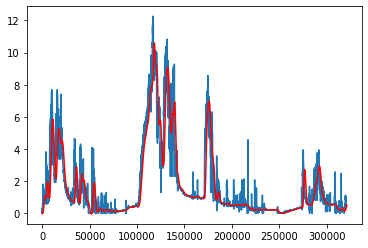

In [12]:
plt.plot(df_EDA['EDA'])
plt.plot(df_EDA_, 'r')

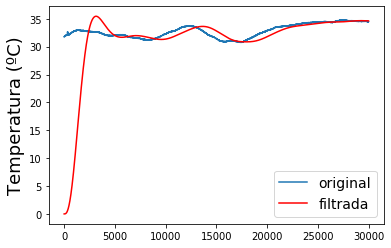

In [23]:
plt.plot(df_TEMP['TEMP'][1:30000])
a=df_TEMP['TEMP'][1:30000]
plt.plot(df_TEMP_[1:30000], 'r')
b=df_TEMP_[1:30000]
plt.ylabel('Temperatura (ºC)',fontsize=18)
plt.legend(['original', 'filtrada'], loc='lower right',fontsize=14)

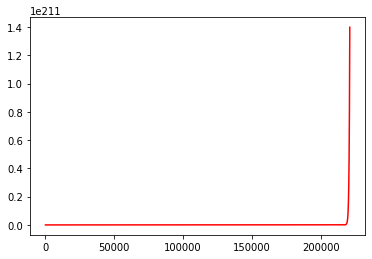

In [27]:
plt.plot(df_TEMP_[1:df_TEMP_.size-100000], 'r')

[]

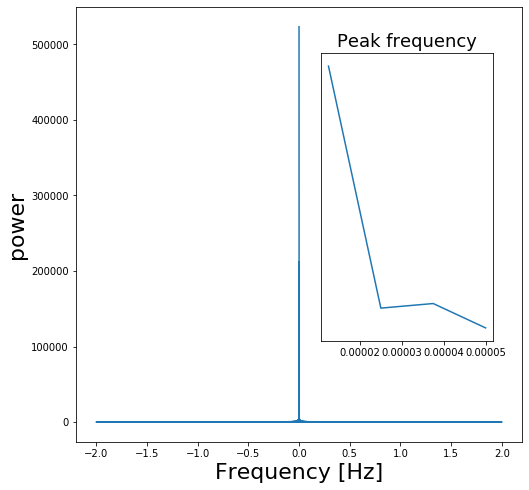

In [17]:
from scipy import fftpack

sig=df_EDA['EDA']
sample_freq=fs['EDA']
time_step=1/sample_freq

# The FFT of the signal
sig_fft = fftpack.fft(sig)

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)

# The corresponding frequencies
sample_freq = fftpack.fftfreq(sig.size, d=time_step)

# Plot the FFT power
plt.figure(figsize=(8, 8))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]',fontsize=22)
plt.ylabel('power',fontsize=22)

# Find the peak frequency: we can focus on only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

# Check that it does indeed correspond to the frequency that we generate
# the signal with
#np.allclose(peak_freq, 1./period)

# An inner plot to show the peak frequency
axes = plt.axes([0.55, 0.3, 0.3, 0.5])
plt.title('Peak frequency', fontsize=18)
plt.plot(freqs[:4], power[:4])
plt.setp(axes, yticks=[])

# scipy.signal.find_peaks_cwt can also be used for more advanced
# peak detection

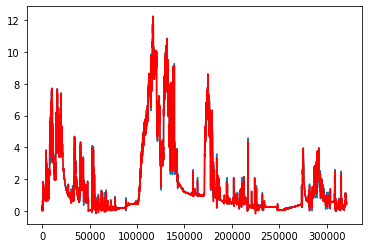

In [7]:
plt.plot(df_EDA['EDA'])
plt.plot(df_EDA_,'r')

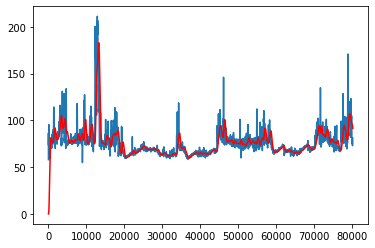

In [39]:
plt.plot(df_HR['HR'])

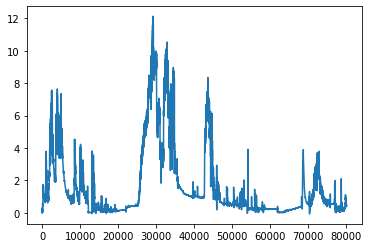

In [5]:
import scipy.signal as scisig
a=scisig.decimate(df_EDA['EDA'], q=4)
plt.plot(scisig.decimate(df_EDA['EDA'], q=4))

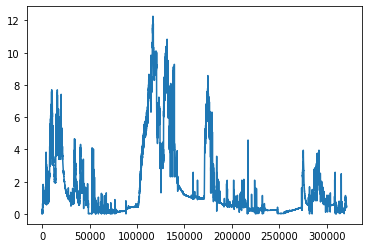

In [4]:
plt.plot(df_EDA['EDA'])

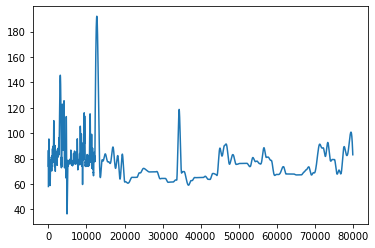

In [57]:
plt.plot(df_TEMP['TEMP']

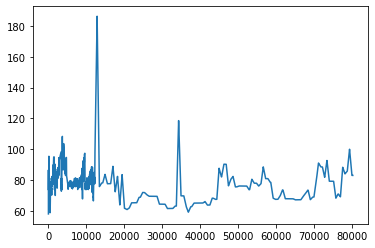

In [56]:

plt.plot(df_HR['HR'].interpolate(method='linear'))

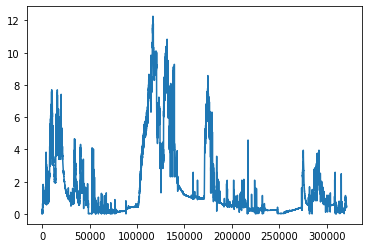

In [2]:
plt.plot(df_EDA['EDA'])

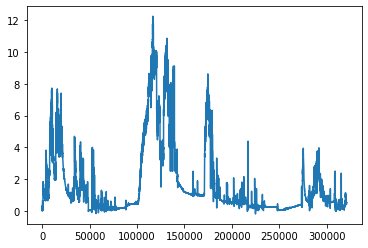

In [4]:
plt.plot(df_EDA['EDA'])

NameError: name 'Q1_HR' is not defined

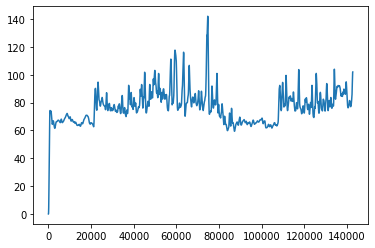

In [17]:
plt.plot(df_HR['HR'])
plt.plot(df_HR[(df_HR < (Q1_HR - 1.5 * IQR_HR)) |(df_HR > (Q3_HR +   1.5*IQR_HR))], 'r')



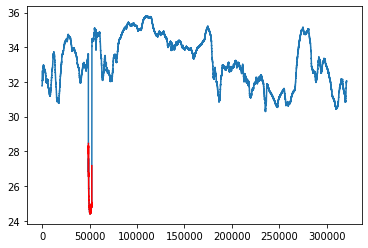

In [18]:
Q1_TEMP = df_TEMP.quantile(0.25)
Q3_TEMP = df_TEMP.quantile(0.75)
IQR_TEMP = Q3_TEMP - Q1_TEMP
plt.plot(df_TEMP['TEMP'])
plt.plot(df_TEMP[(df_TEMP < (Q1_TEMP - 1.5 * IQR_TEMP)) |(df_TEMP > (Q3_TEMP +   1.5*IQR_TEMP))], 'r')

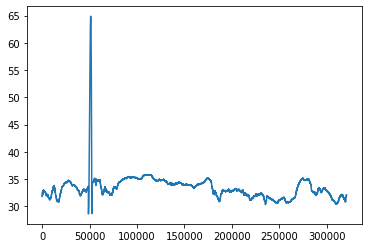

In [34]:
df_TEMP[(df_TEMP < (Q1_TEMP - 1.5 * IQR_TEMP)) |(df_TEMP > (Q3_TEMP +   1.5*IQR_TEMP))]=np.nan
df_TEMP['TEMP']=df_TEMP['TEMP'].interpolate(method='cubic')
plt.plot(df_TEMP['TEMP'])

In [45]:
df_TEMP['TEMP']


array([1.53675607e-08, 1.07524647e-07, 3.83802866e-07, ...,
       3.10851161e+01, 3.10852350e+01, 3.10853550e+01])

In [42]:
windsize=[5,15,30]    
window=1200
step=600
EDA_=[]

for i in range(window, len(df_EDA)-window, step):

    Q1_EDA = df_EDA[i:i-window].quantile(0.25)
    Q3_EDA = df_EDA[i:i-window].quantile(0.75)
    IQR_EDA = Q3_EDA - Q1_EDA
    df_EDA[((df_EDA[i:i-window] < (Q1_EDA - 1.5 * IQR_EDA)) or df_EDA[i:i-window] > (Q3_EDA + 1.5 * IQR_EDA))]=np.nan



SyntaxError: invalid syntax (<ipython-input-42-f109c9e0fc4a>, line 11)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
import cvxEDA
from IPython.display import display
df_pain= pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\basals\MG2318003_mig_16_20180719.csv', names=["pain","TEMP","EDA","HR"])
pain=df_pain['pain']
pain.drop(pain.head(60).index,inplace=True)
pain.index = range(0,len(pain) )
df=df_pain
df.drop(df.tail(30).index,inplace=True)
#del (df['alarm'])
df['pain']=pain
df.to_csv(r'C:\Users\Carlos\Documents\UPM\TFM\Experiments_dataset\raw\Migraine6.csv', index=None, header=True)

In [67]:
df.to_csv(r'C:\Users\Carlos\Documents\UPM\TFM\Experiments_dataset\raw\Basal1.csv', index=None, header=True)


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
import cvxEDA
from IPython.display import display
import scipy.signal as scisig

df_EDA = pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\basals\raw_20180607\Dataexport\EDA.csv', names=["EDA"])
df_TEMP = pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\basals\raw_20180607\Dataexport\TEMP.csv', names=["TEMP"])
df_HR = pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\basals\raw_20180607\Dataexport\HR.csv', names=["HR"])
#df_pain= pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\experiments_LSTM\MG2318003\basals\MG2318003_mig_1_20180606.csv', names=['alarm',"pain","EDA","TEMP","HR"])

EDA=scisig.decimate(df_EDA['EDA'],q=4)
EDA=scisig.decimate(EDA,q=6)
EDA=scisig.decimate(EDA,q=10)

TEMP=scisig.decimate(df_TEMP['TEMP'],q=4)
TEMP=scisig.decimate(TEMP,q=6)
TEMP=scisig.decimate(TEMP,q=10)

HR=scisig.decimate(df_HR['HR'],q=6)
HR=scisig.decimate(HR,q=10)




In [41]:
df_HR.drop(df.tail(1).index, inplace=True)

In [66]:
df['HR']=HR
df['pain']=np.zeros(len(df['EDA']))

In [10]:
df

,meanTEMP5,meanHR5,meanTEMP15,meanHR15,meanTEMP30,meanHR30,stdTEMP5,stdHR5,stdTEMP15,stdHR15,...,maxdiffEDA_tonic5,maxdiffEDA_tonic15,maxdiffEDA_tonic30,countEDA_smna5,countEDA_smna15,countEDA_smna30,maxEDA_smna5,maxEDA_smna15,maxEDA_smna30,pain
0,-0.701542,-0.072047,-0.701542,-0.072047,-0.701542,-0.072047,0.060125,0.193686,0.060125,0.193686,...,-0.012559,-0.012559,-0.012559,0,0,0,0.425226,0.425226,0.425226,0.046064
1,-0.598054,0.350925,-0.598054,0.350925,-0.598054,0.350925,0.140743,0.492401,0.140743,0.492401,...,-0.012559,-0.012559,-0.012559,1,1,1,1.069901,1.069901,1.069901,0.046891
2,-0.559304,0.571335,-0.559304,0.571335,-0.559304,0.571335,0.132316,0.522830,0.132316,0.522830,...,-0.012559,-0.012559,-0.012559,1,1,1,1.069901,1.069901,1.069901,0.047732
3,-0.492301,0.453928,-0.492301,0.453928,-0.492301,0.453928,0.164666,0.499028,0.164666,0.499028,...,-0.012559,-0.012559,-0.012559,1,1,1,1.069901,1.069901,1.069901,0.048587
4,-0.427981,0.405137,-0.427981,0.405137,-0.427981,0.405137,0.195850,0.457703,0.195850,0.457703,...,-0.012559,-0.012559,-0.012559,1,1,1,1.069901,1.069901,1.069901,0.049456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302,-1.362982,0.958802,-1.494082,0.965832,-1.384890,0.350824,0.087900,0.427244,0.108303,0.631964,...,0.001622,-0.008214,0.042800,0,11,74,0.478005,2.743015,11.183550,NaN
1303,-1.286901,0.822926,-1.466329,0.933801,-1.384243,0.369189,0.116752,0.531411,0.146700,0.658693,...,0.001560,-0.008214,0.042800,0,8,74,0.478005,2.743015,11.183550,NaN
1304,-1.208321,0.758671,-1.432088,0.877906,-1.379571,0.390906,0.137888,0.583205,0.183157,0.683295,...,-0.005455,-0.008214,0.042800,1,9,75,2.036090,2.743015,11.183550,NaN
1305,-1.129661,0.601142,-1.392071,0.805445,-1.373254,0.402600,0.134913,0.653724,0.210430,0.713732,...,-0.005455,-0.008214,0.042800,1,9,75,2.036090,2.743015,11.183550,NaN


In [11]:
EDA_scaled

array([[0.01624076],
       [0.01642935],
       [0.01751526],
       ...,
       [0.05613584],
       [0.05619472],
       [0.05621986]])

In [29]:
import pandas as pd
df= pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\Experiments_dataset\stadistics_norm\Migraine5.csv')
df

,meanTEMP5,meanHR5,meanTEMP15,meanHR15,meanTEMP30,meanHR30,stdTEMP5,stdHR5,stdTEMP15,stdHR15,...,maxdiffEDA_tonic5,maxdiffEDA_tonic15,maxdiffEDA_tonic30,countEDA_smna5,countEDA_smna15,countEDA_smna30,maxEDA_smna5,maxEDA_smna15,maxEDA_smna30,pain
0,0.852256,0.430475,0.910557,0.432065,0.955684,0.412859,0.001906,0.000851,0.001906,0.000851,...,-0.007110,-0.007110,-0.007110,0,0,0,0.519012,0.519012,0.519012,0.000033
1,0.879083,0.476497,0.930453,0.372759,0.910792,0.374711,-0.004614,0.005571,0.007983,0.005571,...,-0.007110,-0.007110,-0.007110,0,0,0,0.519012,0.519012,0.519012,0.000034
2,0.903618,0.515199,0.887543,0.387737,0.922298,0.447895,0.009355,0.015505,-0.016168,0.015505,...,-0.007110,-0.007110,-0.007110,0,0,0,0.519012,0.519012,0.519012,0.000034
3,0.911939,0.414336,0.914567,0.462197,0.909868,0.501491,0.011357,0.017534,0.022985,0.030140,...,-0.007110,-0.007110,-0.007110,0,0,0,0.519012,0.519012,0.519012,0.000035
4,0.930052,0.420300,0.927063,0.411037,0.894010,0.464678,0.006398,0.014647,-0.012497,0.048115,...,-0.007110,-0.007110,-0.007110,0,0,0,0.519012,0.519012,0.519012,0.000035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,0.933084,0.478326,0.923287,0.475607,0.910349,0.483811,0.000352,0.006264,0.011142,0.007153,...,0.006115,0.001517,-0.009600,-9,47,88,1.453965,4.890465,3.420937,NaN
2170,0.932969,0.473621,0.925466,0.474363,0.911079,0.483531,0.000530,0.008057,0.009289,0.007790,...,0.007531,-0.000498,0.015389,0,-51,40,2.638177,-0.629860,1.183070,NaN
2171,0.932552,0.468798,0.927253,0.473655,0.911797,0.483248,0.000870,0.008000,0.007442,0.008586,...,0.001939,-0.013744,0.012788,2,28,-87,3.102689,0.785270,6.812967,NaN
2172,0.931889,0.465956,0.928637,0.473701,0.912512,0.483259,0.001154,0.005873,0.005714,0.008589,...,0.008857,0.002864,0.004429,2,60,73,3.181666,2.798940,0.402356,NaN


In [32]:
df['pain'][2114]
df.drop(df.tail(30).index, inplace=True)

In [33]:
df.to_csv(r'C:\Users\Carlos\Documents\UPM\TFM\Experiments_dataset\stadistics_norm\Migraine5.csv', index=None, header=True)

In [3]:
df = pd.read_csv(r'C:\Users\Carlos\Documents\UPM\TFM\Experiments_dataset\stadistics_std\Basal1.csv')

In [18]:
df_HR.to_csv(r'C:\Users\Carlos\Documents\UPM\TFM\Documentos\HR_filtro.csv', index=None, header=True)

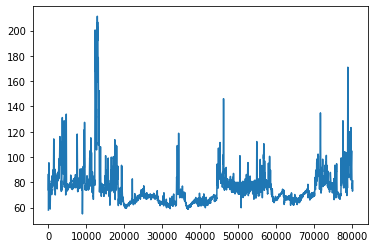

In [27]:
plt.plot(df_HR['HR'])

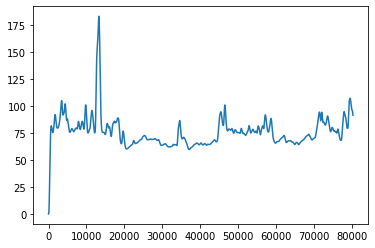

In [28]:
plt.plot(df_HR_)
df_HR['filtrado']=df_HR_

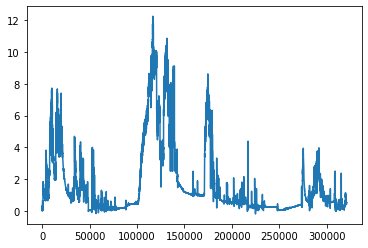

In [15]:
plt.plot(df_EDA['EDA'])

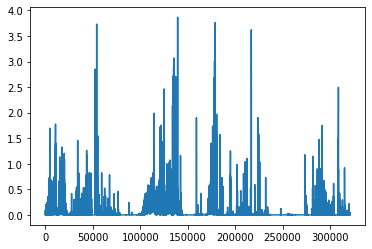

In [10]:
plt.plot(df_EDA['EDA_phasic'])

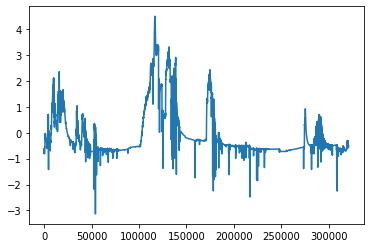

In [11]:
plt.plot(df_EDA['EDA_tonic'])

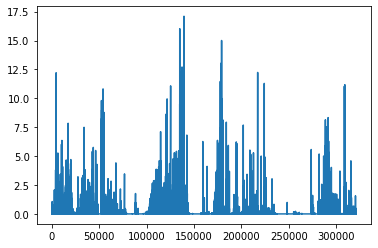

In [12]:
plt.plot(df_EDA['EDA_smna'])

In [33]:
d={'maxHR30':df['maxHR30']}
df=pd.DataFrame(data=d)
df.to_csv(r'C:\Users\Carlos\Documents\UPM\TFM\Documentos\outlayers.csv', index=None, header=True)

In [12]:
Q1_TEMP = df['maxHR30'].quantile(0.25)
Q3_TEMP = df['maxHR30'].quantile(0.75)
IQR_TEMP = Q3_TEMP - Q1_TEMP
a=df['maxHR30']
b=a[(a < (Q1_TEMP - 1.5 * IQR_TEMP)) | (a > (Q3_TEMP +   1.5*IQR_TEMP))]

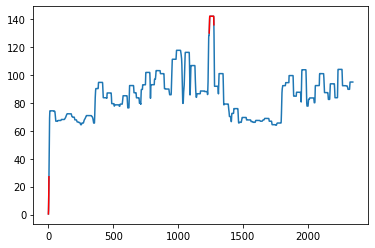

In [25]:
plt.plot(df['maxHR30'])
#plt.plot(a[(a < (Q1_TEMP - 1.5 * IQR_TEMP)) | (a > (Q3_TEMP +   1.5*IQR_TEMP))], 'r')
plt.plot(df['maxHR30'][(df['maxHR30'] < (Q1_TEMP - 1.5 * IQR_TEMP))], 'r')
plt.plot(df['maxHR30'][(df['maxHR30'] > (Q3_TEMP +   1.5*IQR_TEMP))], 'r')
#plt.plot(df['maxHR30'][(df['maxHR30'] < (Q1_TEMP - 1.5 * IQR_TEMP)) |(df['maxHR30'] > (Q3_TEMP +   1.5*IQR_TEMP))], 'r', ls='',ms=5, marker='.')

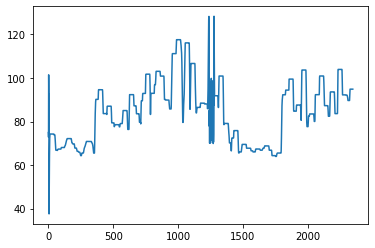

In [32]:
import random

media=df['maxHR30'].mean()
desviacion=df['maxHR30'].std()
for i in range (len(a)):
    if (a[i] < (Q1_TEMP - 1.5 * IQR_TEMP)) |(a[i] > (Q3_TEMP +   1.5*IQR_TEMP)):
        aleatorio=random.uniform(media-desviacion, media+desviacion)
        a[i]= aleatorio
plt.plot(a)

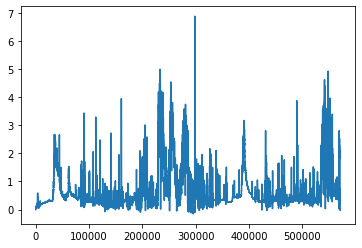

In [2]:
plt.plot(df_EDA['EDA'])